In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import mne
import sys
import pyedflib
import matplotlib.pyplot as plt
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath)) 

In [31]:
import sys, importlib.util, os
from src.utils_io import set_seeds, edfMetadata, read_channel, read_annotations
from src.preprocessing import _infer_subject_number_from_fname, _infer_run_number_from_fname, MI_map


In [27]:
EDFreader.close()

In [28]:
rawDataPath = f"{parentPath}/data/raw/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf"
run = _infer_run_number_from_fname(Path(rawDataPath).name)
subj = _infer_subject_number_from_fname(Path(rawDataPath).name)
EDFreader = pyedflib.EdfReader(rawDataPath)
edf_metadata = edfMetadata(EDFreader)
annotations = read_annotations(reader=EDFreader)


In [41]:
print("nChannels:", edf_metadata["nChannels"])
print("channelLabels:", edf_metadata["channelLabels"])
print("sampleRate (first trial):", edf_metadata["sampleRates"][:1])
print("prefilter (first trial):", edf_metadata["prefilter"][:1])
print("unique annotations:", set(a["description"] for a in annotations))
print("annotation:MI", set(MI_map[a["description"]] for a in annotations))


nChannels: 64
channelLabels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
sampleRate (first trial): [160.0]
prefilter (first trial): ['HP:0Hz LP:0Hz N:0Hz']
unique annotations: {np.str_('T1'), np.str_('T2'), np.str_('T0')}
annotation:MI {'Rest', 'Left MI', 'Right MI'}


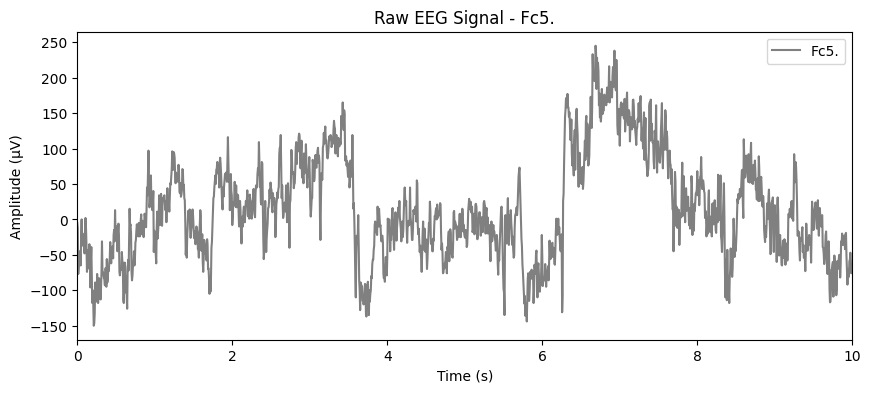

In [ ]:
# Plot a single channel (e.g., first channel)
channel_number = 0  # first channel
channel_label = edf_metadata["channelLabels"][channel_number]          
time, signal, fs, channel_label = read_channel(EDFreader, channel_label, start_sec=0, stop_sec=10)  # first 10s


plt.figure(figsize=(10, 4))
plt.plot(time, signal, label=channel_label, color = 'grey')
plt.title(f"Raw EEG Signal - {channel_label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.xlim(0, 10)
plt.legend()
# plt.grid()
plt.show()

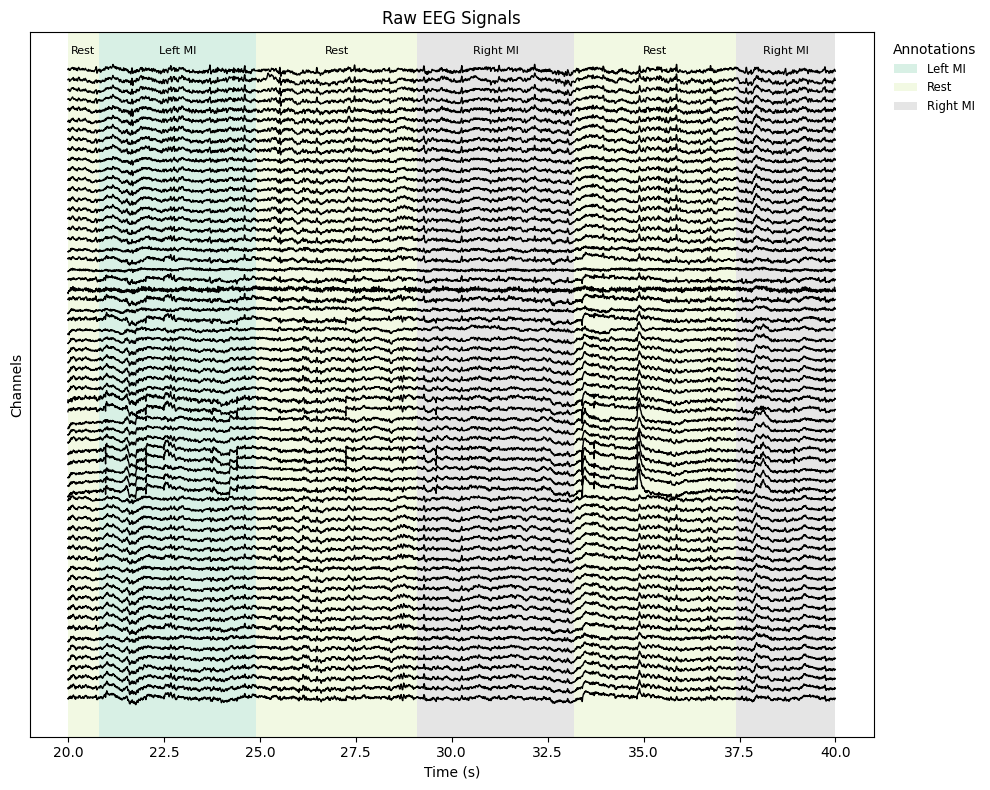

In [42]:
# Plot multiple channels with annotations
start_sec = 20
stop_sec = 40

plt.figure(figsize=((stop_sec-start_sec)/2, 8))
for channel_label in edf_metadata["channelLabels"]:
    time, signal, fs, channel_label = read_channel(EDFreader, channel_label, start_sec=start_sec, stop_sec=stop_sec)
    plt.plot(time, signal + 300 * edf_metadata["channelLabels"].index(channel_label), # Offset for visibility
             label=channel_label,
             color = "black",
             linewidth=1)  
plt.title(f"Raw EEG Signals")
plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.yticks([])  # Hide y-ticks for clarity


for a in annotations:
    a["description"] = MI_map.get(a.get("description", ""), a.get("description", ""))

# Keep only annotations that intersect the visible window
visible_anns = []
for a in annotations:
    a_start = float(a["onset_sec"])
    a_stop  = a_start + max(0.0, float(a["duration_sec"]))
    inter_start = max(start_sec, a_start)
    inter_stop  = min(stop_sec,  a_stop)
    if inter_stop > inter_start or (a_stop == a_start and start_sec <= a_start <= stop_sec):
        visible_anns.append({
            "start": inter_start,
            "stop": inter_stop,
            "desc": a["description"] or "Event"
        })

# 3) Draw spans/lines that cover the full stacked y-range
ax = plt.gca()
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin

uniq_desc = sorted({v["desc"] for v in visible_anns}) or ["Event"]
cmap = plt.cm.Pastel2
color_map = {d: cmap(i / max(1, len(uniq_desc)-1)) for i, d in enumerate(uniq_desc)}

for v in visible_anns:
    c = color_map[v["desc"]]
    if v["stop"] > v["start"]:
        # duration event -> shaded span
        x_mid = 0.5 * (v["start"] + v["stop"])
        ax.axvspan(xmin=v["start"], xmax=v["stop"], facecolor=c, alpha=0.5, edgecolor="none")
        ax.text(x_mid, ymax - 0.02*yrange, v["desc"],
                ha="center", va="top", fontsize=8, color="black", clip_on=False)
    else:
        # instant event -> dashed line
        ax.axvline(v["start"], color=c, linestyle="--", linewidth=1)
        ax.text(v["start"], ymax - 0.02*yrange, v["desc"],
                ha="left", va="top", fontsize=8, color="black", rotation=90, clip_on=False)

# legend for annotation types 
from matplotlib.patches import Patch
ann_handles = [Patch(facecolor=color_map[d], alpha=0.5, label=d, edgecolor='none')
                for d in uniq_desc]
ax.legend(handles=ann_handles, title="Annotations",
            loc="upper left", bbox_to_anchor=(1.01, 1.0),
            frameon=False, fontsize='small')

plt.tight_layout()
plt.savefig(f"{parentPath}/results/rawEEGsignals.png")
plt.show()

## MNE based data loading

In [ ]:
## Load EDF file using mne python
# rawData = Path(f"{parentPath}/data/raw/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf")
# raw = mne.io.read_raw_edf(str(rawData), preload=True, verbose=False)
# print(raw)
# print("Sampling rate:", raw.info["sfreq"], "Hz")

In [ ]:
# # basic clean: notch + bandpass + average reference
# raw_proc = raw.load_data()
# # power noise =  60 Hz for US, 50 elsewhere
# raw_proc.notch_filter([60], verbose=False)
# raw_proc.filter(l_freq=1., h_freq=40., phase='zero', fir_design='firwin', verbose=False)
# raw_proc, _ = mne.set_eeg_reference(raw_proc, 'average')
# print(raw_proc)


In [ ]:
# # visualize raw data
# mne.viz.plot_raw(raw_proc, duration=5.0, n_channels=16, scalings="auto", title="Cleaned EEG (5s)")


In [ ]:
# raw.plot_psd(fmin=1, fmax=40, average=True)

In [ ]:
# # quick PSD (Welch)
# raw_proc.plot_psd(fmin=1, fmax=40, average=True)


: 